# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# Импортируем необходимые библиотеки
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Загружаем данные
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('autos.csv')
# Просматриваем данные
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Данные содержат следующие признаки:
- DataCrawled - дата скачивания анкеты из базы;
- VehicleType - тип автомобильного кузова;
- RegistrationYear - год регистрации автомобиля;
- Gearbox - тип коробки передач;
- Power - мощность (л.с.);
- Model - модель автомобиля;
- Kilometer - пробер (км);
- RegistrationMonth - месяц регистрации автомобиля;
- FuelType - тип топлива;
- Brand - марка автомобиля;
- NotRepaired - была машина в ремонте или нет;
- DataCreated - дата создания анкеты;
- NumberOfPictures - количество фотографий автомобиля;
- PostalCode - почтовый индекс владельца анкеты (пользователя);
- LastSeen - дата последней активности пользователя
Целевой признак:
- Price - цена (евро)

**Вывод:**
1. Имеются столбцы, которые не влияют на цену автомобиля (DataCrawled, RegistrationMonth, PostCode, LastSeen, NumberOfPictures) и их можно удалить. Столбец RegistrationMonth тоже можно удалить, т.к. в основном используется год регистрации и такой параметр как месяц регистрации может быть важен только для автомомбилей, которым меньше года. Т.к. эти столбцы не влияют на цену, то мы их не будет включать в модель и исследовать.
2. Есть столбцы, в которых присутствуют пропуски данных. Такие как VehicleType, Gearbox, Model, FuelType, NotRepaired. При дальнейшем изучении будет принято решение или об удалении или о заполнении недостающих значений в столбцах.
3. Имеются нулевые значения в столбце цена (целевой признак) и также в этом столбце имеются выбросы, которые значительно смещают среднее арифметическое значение.
4. Имеются нереальные годы регистрации, причем как очень маленькие, так и очень большие.
5. Имеются автомобили с нулевой и очень большой мощностью.

In [5]:
# Удалим лишние столбцы, которые не влияют на целевой признак
not_features = ['DateCrawled', 'RegistrationMonth', 'PostalCode', 'LastSeen', 'NumberOfPictures']
data = data.drop(not_features, axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016-03-24 00:00:00
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016-03-24 00:00:00
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016-03-14 00:00:00
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016-03-17 00:00:00
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016-03-31 00:00:00


**Обработаем пропуски в данных**

In [6]:
# Обработаем пропуски в типе кузова и модели
data['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [7]:
# Наравне с типами кузова которые существуют в реальности, имеются как пропуски, так и тип кузова под названием other.
# Посмотрим, сколько имеется пропусков в типе кузова и как заполнены другие столбцы в таких строках.
data[data['VehicleType'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37490 entries, 0 to 354365
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             37490 non-null  int64 
 1   VehicleType       0 non-null      object
 2   RegistrationYear  37490 non-null  int64 
 3   Gearbox           27520 non-null  object
 4   Power             37490 non-null  int64 
 5   Model             30662 non-null  object
 6   Kilometer         37490 non-null  int64 
 7   FuelType          20195 non-null  object
 8   Brand             37490 non-null  object
 9   NotRepaired       16919 non-null  object
 10  DateCreated       37490 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.4+ MB


Пропуски в типах кузова можно заполнить исходя из модели автомобиля. При этом всего для 30662 объектов указана модель, значит только для них можно выявить тип кузова на основе схожих данных, а остальные данные можнг заменить на значение other.

In [8]:
data['Model'] = data['Model'].fillna('other')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


In [10]:
# аналогично заполняем тип кузова
data['VehicleType'] = data['VehicleType'].fillna('other')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


In [11]:
# Заполним пропуски в коробке передач
# Проверим сколько в базе автомобилей с различными коробками передач
data['Gearbox'].value_counts(dropna=False)

manual    268251
auto       66285
NaN        19833
Name: Gearbox, dtype: int64

В базе больше всего автомобилей с ручной коробкой передач. Заполним пропуски значением other.

In [12]:
data['Gearbox'] = data['Gearbox'].fillna('other')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


In [13]:
# Аналогично столбцу коробки передач проведем заполнение пропусков по столбцу тип топлива
data['FuelType'].value_counts(dropna=False)

petrol      216352
gasoline     98720
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [14]:
data['FuelType'] = data['FuelType'].fillna('other')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
 10  DateCreated       354369 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


In [15]:
# Заполним пропуски в столбце данных о ремонте
data['NotRepaired'].value_counts(dropna=False)

no     247161
NaN     71154
yes     36054
Name: NotRepaired, dtype: int64

Иходя из соотношения классов видим, что автомобилей у которых не было ремонтов почти в 7 раза больше, чем автомобелей, которые были в ремонте. Пропуски в данных, скорее всего обусловлены тем, что при заполнении анкеты, т.к. не было ремонтов графа было просто пропущена. Заполним пропуски значением no.

In [16]:
data['NotRepaired'] = data['NotRepaired'].fillna('no')

In [17]:
data['NotRepaired'].value_counts(dropna=False)

no     318315
yes     36054
Name: NotRepaired, dtype: int64

Посмотрим, какие значеня находятся в целевом столбце 

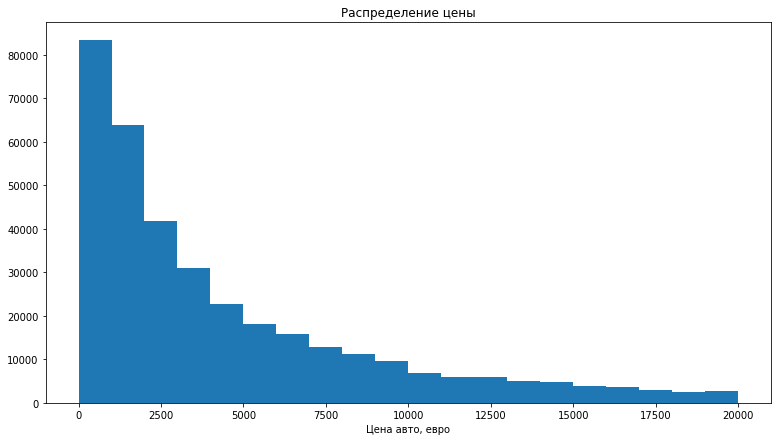

In [18]:
plt.figure(figsize=(13, 7))
plt.hist(data['Price'], bins=20)
plt.title('Распределение цены')
plt.xlabel('Цена авто, евро')
plt.show()

<AxesSubplot:xlabel='Price'>

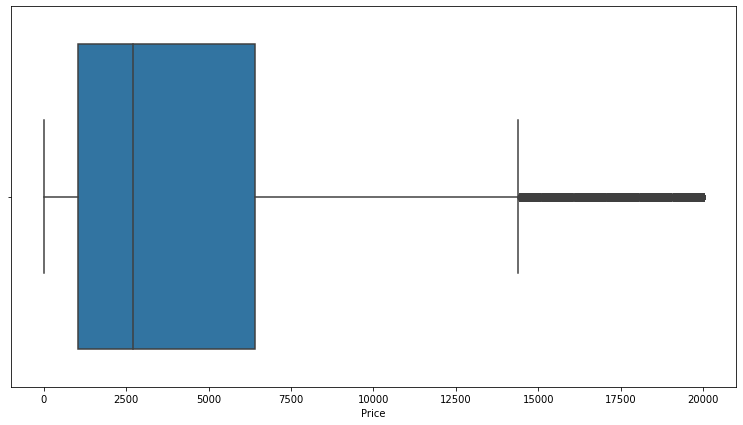

In [19]:
plt.figure(figsize=(13, 7))
sns.boxplot(data['Price'])

По графику можно увидеть, что данные имеют распределением Пуассона. Граница правого уса заканчивается на 14525 тыс. евро, далее идут более дорогие автомобили. необходимо более подбробно ознакомиться с такими машинами и определиться, не ошибка ли это. Также большое количество автомобилей стоит от 0 до 500 евро. С ними тоже необходимо познакомиться более подробно.

In [20]:
data[data['Price'] < 50]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated
7,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,2016-03-21 00:00:00
40,0,other,1990,other,0,corsa,150000,petrol,opel,no,2016-03-26 00:00:00
59,1,suv,1994,manual,286,other,150000,other,sonstige_autos,no,2016-03-29 00:00:00
89,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,2016-03-28 00:00:00
111,0,other,2017,manual,0,golf,5000,petrol,volkswagen,no,2016-03-19 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,other,2000,manual,65,corsa,150000,other,opel,yes,2016-03-09 00:00:00
354238,0,small,2002,manual,60,fiesta,150000,petrol,ford,no,2016-03-20 00:00:00
354248,0,small,1999,manual,53,swift,150000,petrol,suzuki,no,2016-03-24 00:00:00
354277,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,2016-03-10 00:00:00


In [21]:
data[data['Price'] == 0]['NotRepaired'].value_counts()

no     8767
yes    2005
Name: NotRepaired, dtype: int64

In [22]:
data[data['Price'] <50]['NotRepaired'].value_counts()

no     10130
yes     2293
Name: NotRepaired, dtype: int64

Анализируя данные автомобилей по низким ценам можно сделать следующие выводы:
1. По большей части до 50 евро продаются битые машины.
2. Очень большое количество автомобилей, где цена равна нулю. Возможно люди просто хотят избавиться от старого ненужного авто, но возможно, что это ошибка заполнения данных в анкете. И так как невозможно в данном случае правильно определиться со значением цены, то автомобили с нулевой ценой лучше исключить из датасета.
3. Если предположить, что машина битая, то машина может продаваться за любую цену, но если машина целая, то она не может стоить меньше 100 евро. Поэтому небитые машины с ценой менее 100 евро, тоже необходимо исключить из датасета.

Посмотрим на очень дорогие автомобили

In [23]:
data[data['Price'] > 15000].head(30)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes,2016-03-24 00:00:00
14,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no,2016-03-21 00:00:00
33,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no,2016-03-25 00:00:00
172,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no,2016-03-07 00:00:00
179,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no,2016-03-08 00:00:00
204,18400,wagon,2011,auto,313,5er,150000,gasoline,bmw,no,2016-03-31 00:00:00
236,15700,sedan,2011,manual,170,golf,90000,gasoline,volkswagen,no,2016-03-05 00:00:00
282,18700,coupe,2009,auto,213,mustang,80000,petrol,ford,no,2016-03-06 00:00:00
287,16150,suv,2011,manual,150,tiguan,30000,petrol,volkswagen,no,2016-03-19 00:00:00
313,16500,coupe,2007,manual,265,z_reihe,150000,petrol,bmw,no,2016-03-05 00:00:00


Выведенные данные показали, что в диапазон цен свыше 15000 попали дейсвительно дорогие автомобили, соотвественно выбросов нет и удаление данных не требуется.

In [24]:
# Удаляем автомобили с нулевой ценой и не битые автомобили стоящие меньше 100 евро
data = data[data['Price'] != 0]
data = data.drop(data[(data['Price'] < 100) & (data['NotRepaired'] != 'no')].index)

In [25]:
# Проверяем
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343040 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343040 non-null  int64 
 1   VehicleType       343040 non-null  object
 2   RegistrationYear  343040 non-null  int64 
 3   Gearbox           343040 non-null  object
 4   Power             343040 non-null  int64 
 5   Model             343040 non-null  object
 6   Kilometer         343040 non-null  int64 
 7   FuelType          343040 non-null  object
 8   Brand             343040 non-null  object
 9   NotRepaired       343040 non-null  object
 10  DateCreated       343040 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.4+ MB


In [26]:
# выведем уникальные значения даты регистрации
print(data['DateCreated'].sort_values().unique())

['2014-03-10 00:00:00' '2015-03-20 00:00:00' '2015-06-18 00:00:00'
 '2015-08-07 00:00:00' '2015-08-10 00:00:00' '2015-09-04 00:00:00'
 '2015-09-09 00:00:00' '2015-11-02 00:00:00' '2015-11-08 00:00:00'
 '2015-11-10 00:00:00' '2015-11-12 00:00:00' '2015-11-17 00:00:00'
 '2015-11-23 00:00:00' '2015-11-24 00:00:00' '2015-12-05 00:00:00'
 '2015-12-06 00:00:00' '2015-12-17 00:00:00' '2015-12-27 00:00:00'
 '2015-12-30 00:00:00' '2016-01-02 00:00:00' '2016-01-03 00:00:00'
 '2016-01-06 00:00:00' '2016-01-07 00:00:00' '2016-01-08 00:00:00'
 '2016-01-10 00:00:00' '2016-01-13 00:00:00' '2016-01-15 00:00:00'
 '2016-01-16 00:00:00' '2016-01-17 00:00:00' '2016-01-18 00:00:00'
 '2016-01-19 00:00:00' '2016-01-20 00:00:00' '2016-01-22 00:00:00'
 '2016-01-23 00:00:00' '2016-01-24 00:00:00' '2016-01-25 00:00:00'
 '2016-01-26 00:00:00' '2016-01-27 00:00:00' '2016-01-28 00:00:00'
 '2016-01-29 00:00:00' '2016-01-30 00:00:00' '2016-01-31 00:00:00'
 '2016-02-01 00:00:00' '2016-02-02 00:00:00' '2016-02-03 00:00

In [27]:
# последняя дата регистрации пользователя на сайте 07.04.2020, следовательно все данные старше 2016 года удаляем, 
# т.к. это явные ошибки
data = data.drop(data[data.RegistrationYear > 2016].index)

(1980.0, 2025.0)

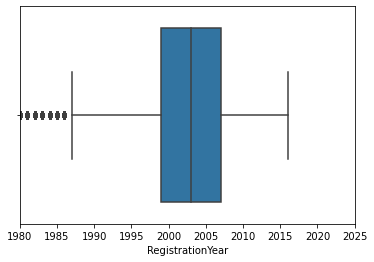

In [28]:
# Строим боксплот чтобы посмотреть нижний предел выбросов и удалить их
sns.boxplot(data['RegistrationYear'])
plt.xlim(1980, 2025)

In [29]:
# На основании графика, удалим строки в которых находятся даты регистрации меньше 1985 года
data = data.drop(data[data.RegistrationYear < 1985].index)

(0.0, 500.0)

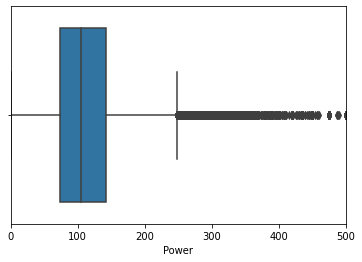

In [30]:
# Строким ящик с усами для признака мощности автомобилей
sns.boxplot(data['Power'])
plt.xlim(0, 500)

In [31]:
# Удаляем выбросы по мощности больше 250
data = data.drop(data[data.Power > 250].index)

In [32]:
# Столбец DateCreated нам больше не нужен удаляем его
data = data.drop('DateCreated', axis=1)

In [33]:
# Проверяем
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317383 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             317383 non-null  int64 
 1   VehicleType       317383 non-null  object
 2   RegistrationYear  317383 non-null  int64 
 3   Gearbox           317383 non-null  object
 4   Power             317383 non-null  int64 
 5   Model             317383 non-null  object
 6   Kilometer         317383 non-null  int64 
 7   FuelType          317383 non-null  object
 8   Brand             317383 non-null  object
 9   NotRepaired       317383 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.6+ MB


**Проверим на дубликаты**

In [34]:
# Проверим датасет на полные дубликаты и удалим их
data.duplicated().sum()

48058

В датасете имеется 48058 дубликатов, что говорит о том, что продается большое количество похожих автомобилей или может быть анкета на один и то же автомобиль заполнялась не один раз. Уберем дубликаты, чтобы не переобучать модель.

In [35]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269325 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             269325 non-null  int64 
 1   VehicleType       269325 non-null  object
 2   RegistrationYear  269325 non-null  int64 
 3   Gearbox           269325 non-null  object
 4   Power             269325 non-null  int64 
 5   Model             269325 non-null  object
 6   Kilometer         269325 non-null  int64 
 7   FuelType          269325 non-null  object
 8   Brand             269325 non-null  object
 9   NotRepaired       269325 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.6+ MB


**Проверим признаки на мульколлинеарность**

<AxesSubplot:>

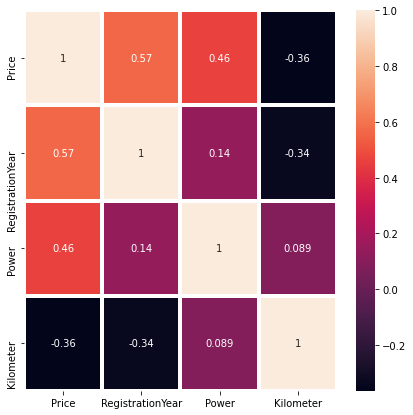

In [36]:
# Определим корреляцию между признаками
plt.rcParams['figure.figsize'] = (7.0, 7.0)
sns.heatmap(data.corr(), annot=True, linewidths=3, linecolor='white')

**Вывод:** Цена незначительно зависит от года регистрации, обучающие признаки не коррелируют друг с другом, следовательно удаление признаков не требуется.

**Подготовка датасета для обучения различных моделей**

Проведем коидрование категориальных признаков. Т.к. будем использовать различные модели, в зависимости от модели необходимо применять различные типы кодирования. В случае линейной регрессии подойдет техника прямого кодирования, а в случае деревьев и лесов - порядквого кодирования, поэтому в будет подготовлено два набора данных для обоих видов кодирования. После кодирования будет сделано масштабирование числовых признаков. В случае бустинговых моделей кородквка не требуется, поэтому будет подгототвлен третий датасет без кодировки, но с масштабированием.

In [37]:
cat_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# Прямое кодирование
data_ohe = pd.get_dummies(data, drop_first=True, columns=cat_columns)
display(data_ohe.head(10))

# Порядковое кодирование
encoder = OrdinalEncoder()
data_ord = data.copy()
data_ord[cat_columns] = encoder.fit_transform(data_ord[cat_columns])
display(data_ord.head(10))

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,480,1993,0,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,14500,2014,125,30000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,999,1998,101,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
10,2000,2004,105,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,3.0,1993,1.0,0,116.0,150000,6.0,38.0,0.0
1,18300,2.0,2011,1.0,190,166.0,125000,2.0,1.0,1.0
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0
6,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0
8,14500,0.0,2014,1.0,125,60.0,30000,6.0,10.0,0.0
9,999,5.0,1998,1.0,101,116.0,150000,5.0,38.0,0.0
10,2000,4.0,2004,1.0,105,10.0,150000,6.0,19.0,0.0


In [38]:
# Функция деления датасетов на обучающуюи тестовую выборки
def split_data(data):
    target = data['Price']
    features = data.drop('Price', axis=1)
    features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.2, random_state=12345)
    return features_train, features_test, target_train, target_test

In [39]:
# Выборки для прямого кодирования
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = split_data(data_ohe)
# Проверим что получилось
for i in [features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe]:
    print(i.shape)

(215460, 303)
(53865, 303)
(215460,)
(53865,)


In [40]:
# Выборки для порядкового кодирования
features_train_ord, features_test_ord, target_train_ord, target_test_ord = split_data(data_ord)
# Проверим что получилось
for i in [features_train_ord, features_test_ord, target_train_ord, target_test_ord]:
    print(i.shape)

(215460, 9)
(53865, 9)
(215460,)
(53865,)


In [41]:
# Выборки без кодирования
features_train_no, features_test_no, target_train_no, target_test_no = split_data(data)
# Проверим что получилось
for i in [features_train_no, features_test_no, target_train_no, target_test_no]:
    print(i.shape)

(215460, 9)
(53865, 9)
(215460,)
(53865,)


Проведем масштабирование признаков во всех выборках 

In [42]:
# Функция для масштабирования
def scale_data(features_train, features_test):
    numeric = ['RegistrationYear', 'Power', 'Kilometer']
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    return features_train, features_test

In [43]:
# Масштабируем данные для прямого кодирования
features_train_ohe, features_test_ohe = scale_data(features_train_ohe, features_test_ohe)
# Проверим результаты
features_train_ohe.describe()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
count,2.154600e+05,2.154600e+05,2.154600e+05,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,...,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000,215460.000000
mean,-8.151999e-15,-2.512919e-17,-6.689576e-17,0.061571,0.044839,0.075295,0.261209,0.234257,0.035283,0.195308,...,0.017511,0.016653,0.006029,0.002339,0.007472,0.014736,0.001058,0.205180,0.009626,0.107955
std,1.000002e+00,1.000002e+00,1.000002e+00,0.240375,0.206951,0.263867,0.439294,0.423534,0.184494,0.396438,...,0.131167,0.127967,0.077412,0.048309,0.086120,0.120494,0.032513,0.403834,0.097639,0.310324
min,-3.043294e+00,-1.883259e+00,-3.221099e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.921792e-01,-6.149664e-01,-5.925342e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.043208e-02,-7.615228e-03,5.994644e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.513151e-01,6.175992e-01,5.994644e-01,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.162746e+00,2.582559e+00,5.994644e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
# Масштабируем данные для порядкового кодирования
features_train_ord, features_test_ord = scale_data(features_train_ord, features_test_ord)

In [45]:
# Масштабируем данные без кодирования
features_train_no, features_test_no = scale_data(features_train_no, features_test_no)

**Выводы:**
- Исключены столбцы, которые не влияют на цену, т.е. не являеются обучающими признаками.
- Проведено заполнение пропусков значениями other для полей: тип кузова, тип коробки передач, тип топлива, была машина в ремонте или нет.
- Исключены нулевые цены, а также цены меньше 100 евро на небитые машины.
- Проведено удаление дубликатов.
- Проведена проверка на мультиколлинеарность.
- Датасет разделен на обучающую, валидационную и тестовую выборки для двух кодировок: прямого кодирования, порядкового кодирования, без кодирования.
- Проведено масшатибрование количественных значений.

## Обучение моделей

Обучим следующие модели: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBM.

### Линейная регрессия

Проведем определение оптимальных параметров для линейной регрессии с помощью функционала GridSearchCV.

In [46]:
# Функция для нахождения rmse
def rmse_score(target, predictions):
    rmse = mean_squared_error(target, predictions) ** 0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better = False)

In [ ]:
model = LinearRegression()
parameters = {'fit_intercept': [True, False], 'normalize': [True, False]}
grid = GridSearchCV(model, parameters, cv=5, scoring=scorer, verbose=5)
grid.fit(features_train_ohe, target_train_ohe)
print('RMSE линейная регрессия составляет', grid.best_score_)

In [ ]:
print('Наилучшие подобранные параметры для линейной регрессии', grid.best_params_)

Наилучший RMSE=2488 при GridSearchCV получен для параметров fit_intercept=True и normalize=True.

### Решающее дерево

In [ ]:
tree = DecisionTreeRegressor(random_state=12345)
tree_params = {'max_depth': range(1, 15), 'min_samples_split': range(2, 7)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, verbose=5, scoring=scorer)
tree_grid.fit(features_train_ord, target_train_ord)
print('RMSE для решающего дерева составляет', tree_grid.best_score_)

print('Наилучшие подобранные параметры для решающего дерева', tree_grid.best_params_)

Наилучший RMSE=1835 при GridSearchCV получен для параметров max_depth=14, min_samples_split=6

### Случайный лес

In [ ]:
forest = RandomForestRegressor(random_state=12345, n_estimators=70)
forest_params = {'max_features': ['auto', 'sqrt'], 'max_depth': range(1, 12)}
forest_grid = GridSearchCV(forest, forest_params, cv=5, verbose=5, scoring=scorer)
forest_grid.fit(features_train_ord, target_train_ord)
print('RMSE для случайного леса составляет', forest_grid.best_score_)

print('Наилучшие подобранные параметры для случайного леса', forest_grid.best_params_)

Наилучший RMSE=1753 при GridSearchCV для случайного леса получен для параметров max_depth=11, max_features='sqrt'.

### Light GBM

Несмотря на то, что библиотеки Light GBM и CatBoost не требуют кодирования нечисловых признаков, такие признаки рекомендуется перевести в тип category.

In [47]:
def obg_to_cat(data):
    for i in data.columns:
        col_type = data[i].dtype
        if col_type =='object' or col_type.name =='category':
            data[i] = data[i].astype('category')

In [48]:
obg_to_cat(features_train_no)
features_train_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215460 entries, 326053 to 278446
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       215460 non-null  category
 1   RegistrationYear  215460 non-null  float64 
 2   Gearbox           215460 non-null  category
 3   Power             215460 non-null  float64 
 4   Model             215460 non-null  category
 5   Kilometer         215460 non-null  float64 
 6   FuelType          215460 non-null  category
 7   Brand             215460 non-null  category
 8   NotRepaired       215460 non-null  category
dtypes: category(6), float64(3)
memory usage: 8.0 MB


In [49]:
obg_to_cat(features_test_no)
features_test_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53865 entries, 169592 to 24804
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   VehicleType       53865 non-null  category
 1   RegistrationYear  53865 non-null  float64 
 2   Gearbox           53865 non-null  category
 3   Power             53865 non-null  float64 
 4   Model             53865 non-null  category
 5   Kilometer         53865 non-null  float64 
 6   FuelType          53865 non-null  category
 7   Brand             53865 non-null  category
 8   NotRepaired       53865 non-null  category
dtypes: category(6), float64(3)
memory usage: 2.0 MB


In [50]:
cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

gbm = LGBMRegressor(random_state=12345)
    
g_params = {'n_estimators': [100, 500], 'num_leaves': [31, 41], 'learning_rate': [0.04, 0.06]}

g_grid = GridSearchCV(gbm, g_params, cv=5, verbose=5, scoring=scorer)

g_grid.fit(features_train_no, target_train_no, categorical_feature = cat)

print("RMSE для LGBM составляет ", g_grid.best_score_)


print('Наилучшие подобранные параметры для LGBM', g_grid.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END learning_rate=0.04, n_estimators=100, num_leaves=31; total time=  10.7s
[CV 2/5] END learning_rate=0.04, n_estimators=100, num_leaves=31; total time= 2.1min
[CV 3/5] END learning_rate=0.04, n_estimators=100, num_leaves=31; total time= 1.4min
[CV 4/5] END learning_rate=0.04, n_estimators=100, num_leaves=31; total time= 1.2min
[CV 5/5] END learning_rate=0.04, n_estimators=100, num_leaves=31; total time= 1.3min
[CV 1/5] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time= 4.2min
[CV 2/5] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time= 4.4min
[CV 3/5] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time= 5.5min
[CV 4/5] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time= 4.4min
[CV 5/5] END learning_rate=0.04, n_estimators=100, num_leaves=41; total time= 4.6min
[CV 1/5] END learning_rate=0.04, n_estimators=500, num_leaves=31; total time= 6.2min
[CV 2

Наилучший RMSE=1517 при GridSearchCV для LGBM получен для параметров learning_rate=0.06, e_estimators=500, num_leaves=41.

### CatBoost

Проведем поиск оптимальных параметров для CatBoostRegressor

In [51]:
cbr = CatBoostRegressor(cat_features = cat, loss_function = 'RMSE')
grid = {'learning_rate': [0.1, 0.5], 'iterations': [150, 500]}
cbr_grid = GridSearchCV(cbr, grid, cv=5, verbose=5, scoring=scorer)
cbr_grid.fit(features_train_no, target_train_no)
print('RMSE для CatBoostRegressor составляет ', cbr_grid.best_score_)

print('Наилучшие подобранные параметры для CatBoostRegressor', cbr_grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 4182.7761782	total: 121ms	remaining: 18s
1:	learn: 3930.1483476	total: 190ms	remaining: 14s
2:	learn: 3706.9578117	total: 240ms	remaining: 11.8s
3:	learn: 3498.8516835	total: 293ms	remaining: 10.7s
4:	learn: 3314.5732233	total: 360ms	remaining: 10.4s
5:	learn: 3151.3776963	total: 418ms	remaining: 10s
6:	learn: 3008.0767960	total: 471ms	remaining: 9.61s
7:	learn: 2883.0228254	total: 527ms	remaining: 9.35s
8:	learn: 2775.6598579	total: 582ms	remaining: 9.12s
9:	learn: 2680.1809833	total: 637ms	remaining: 8.92s
10:	learn: 2594.7963103	total: 691ms	remaining: 8.73s
11:	learn: 2510.6847074	total: 744ms	remaining: 8.56s
12:	learn: 2433.0084845	total: 798ms	remaining: 8.41s
13:	learn: 2370.8357586	total: 849ms	remaining: 8.25s
14:	learn: 2310.4547649	total: 905ms	remaining: 8.14s
15:	learn: 2262.4688037	total: 957ms	remaining: 8.02s
16:	learn: 2219.5744714	total: 1.01s	remaining: 7.9s
17:	learn: 2181.4200321	total: 1.06s	re

Наилучший RMSE=1548 с использованием GridSearchCV для CatBoostRegressor получен для параметров iteration=500, learning_rate=0.5.

**Вывод:**
Обучены и подобраны гиперпараметры для 5 различных моделей: линейная регрессия, решающее дерево, случайный лес, CatBoost, LightGBMRegressor. для всех моделей были применена кроссс-валидация, вшитая в метод GridSearchCV.
Наихудшим результатом (2949 евро) обладает модель линейной регрессии, наилучший результат был получен с помощью модели LightGBMRegressor (1685 квро), сравнительно недалеко от него находится результат модели CatBoostRegressor (1726 евро). Исходя из этого можно заключить, что бустинговые модели лучше справились с минимизацией поставленной метрики.

## Анализ моделей

In [52]:
# Создадим таблицу для хранения результатов
d = {'model': [], 'RMSE': [], 'fit_time': [], 'predict_time': []}
results = pd.DataFrame(data = d)
results

,model,RMSE,fit_time,predict_time


In [53]:
# Создадим функцию для добавления результатов в таблицу
def model_rez(model_name, model, features_train, target_train, features_test, target_test):
    rmse, fit_time, pred_time = ml(model, features_train, target_train, features_test, target_test)
    results.loc[len(results)] = [model_name, rmse, fit_time, pred_time]
    if len(results) > 0:
        results.drop_duplicates(inplace = True)

In [54]:
# Функция для расчета параметров
def ml(model, features_train, target_train, features_test, target_test):
    start_fit_time = time.time()
    model.fit(features_train, target_train)
    stop_fit_time = time.time()
    fit_time = stop_fit_time - start_fit_time
    
    start_pred_time = time.time()
    predictions = model.predict(features_test)
    stop_pred_time = time.time()
    pred_time = stop_pred_time - start_pred_time
    
    rmse = mean_squared_error(target_test, predictions) ** 0.5
    return rmse, fit_time, pred_time

In [55]:
# линейная регрессия
lr = LinearRegression(fit_intercept=True, normalize=True)
model_rez('LinearRegression', lr, features_train_ohe, target_train_ohe, features_test_ohe, target_test_ohe)

In [56]:
# решающее дерево
dt = DecisionTreeRegressor(max_depth=14, min_samples_split=6, random_state=12345)
model_rez('DecisionTreeRegressor', dt, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

In [57]:
# случайный лес
rf = RandomForestRegressor(max_depth=11, n_estimators=70, random_state=12345, max_features='sqrt')
model_rez('RandomForestRegressor', rf, features_train_ord, target_train_ord, features_test_ord, target_test_ord)

In [58]:
# Light GBM Regressor
lgbm = LGBMRegressor(learning_rate=0.06, n_estimators=500, num_leaves=41, random_state=12345)
model_rez('LGBMRegressor', lgbm, features_train_no, target_train_no, features_test_no, target_test_no)

In [59]:
# CatBoostRegressor
cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cb = CatBoostRegressor(cat_features=cat, loss_function='RMSE', learning_rate=0.5, iterations=500, random_state=12345)
model_rez('CatBoostRegressor', cb, features_train_no, target_train_no, features_test_no, target_test_no)

0:	learn: 3125.9201701	total: 238ms	remaining: 1m 58s
1:	learn: 2494.5301065	total: 431ms	remaining: 1m 47s
2:	learn: 2206.8846548	total: 645ms	remaining: 1m 46s
3:	learn: 2051.4565958	total: 844ms	remaining: 1m 44s
4:	learn: 1967.6430467	total: 1.04s	remaining: 1m 42s
5:	learn: 1919.1521442	total: 1.18s	remaining: 1m 36s
6:	learn: 1887.2760438	total: 1.35s	remaining: 1m 34s
7:	learn: 1857.4177916	total: 1.51s	remaining: 1m 32s
8:	learn: 1832.2893676	total: 1.69s	remaining: 1m 32s
9:	learn: 1815.1791168	total: 1.85s	remaining: 1m 30s
10:	learn: 1802.4222921	total: 2.02s	remaining: 1m 29s
11:	learn: 1790.7380017	total: 2.18s	remaining: 1m 28s
12:	learn: 1778.9911040	total: 2.37s	remaining: 1m 28s
13:	learn: 1772.5485071	total: 2.54s	remaining: 1m 28s
14:	learn: 1761.4879094	total: 2.75s	remaining: 1m 28s
15:	learn: 1752.8580838	total: 2.94s	remaining: 1m 28s
16:	learn: 1739.8998890	total: 3.08s	remaining: 1m 27s
17:	learn: 1733.9954668	total: 3.23s	remaining: 1m 26s
18:	learn: 1727.9669

In [60]:
results['fit_predict_time'] = results['fit_time'] + results['predict_time']
results

,model,RMSE,fit_time,predict_time,fit_predict_time
0,LinearRegression,2489.230001,18.194254,0.194044,18.388298
1,DecisionTreeRegressor,1814.511795,0.476499,0.011400,0.487899
2,RandomForestRegressor,1748.329992,7.690504,0.362754,8.053258
3,LGBMRegressor,1517.152803,103.550321,2.919826,106.470147
4,CatBoostRegressor,1547.297137,86.588757,0.291034,86.879791


**Вывод:**
Проведенный анализ с проверкой моделей на тестовой выборке показал, что наилучшую метрику RMSE возможно получить с применением библиотеки Light GBM. Близкое к этому значение можно получить с помощью метрики CatBoost, при этом данная метрика как быстрее обучается, так и быстрее предсказывает. Если сравнить суммарное время на fit_predict, то модель CatBoostRegressor выполнила поставленную задачу быстрее, чем LGBMRegressor. Самую высокую скорость, как обучения, так и предсказания показала модель DecisionTreeRegressor.